In [15]:
import numpy as np
import matplotlib.pyplot as plt
from gprm import ReconstructionModel
import pygmt
import geopandas as gpd
import sys
sys.path.append('/Users/simon/GIT/degenerative_art/')
import map_effects as me
sys.path.append('/Users/simon/GIT/agegrid-0.1/')
from run_paleo_age_grids import run_paleo_age_grids
import xarray as xr
from xrspatial import proximity
import gprm.utils.paleogeography as pg


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
Atlantis = ReconstructionModel()

Atlantis.add_continent_polygons('/Users/simon/Documents/2022IMAS-OUC_SOMG/PracFiles/Atlantis2/Atlantis2_continents.gpml')
Atlantis.add_dynamic_polygons('/Users/simon/Documents/2022IMAS-OUC_SOMG/PracFiles/Atlantis2/Atlantis2_topologies.gpml')
Atlantis.add_dynamic_polygons('/Users/simon/Documents/2022IMAS-OUC_SOMG/PracFiles/Atlantis2/Atlantis2_geometries.gpml')
Atlantis.add_rotation_model('/Users/simon/Documents/2022IMAS-OUC_SOMG/PracFiles/Atlantis2/Atlantis2_rotations.rot')

final_grd_sampling = 0.5


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


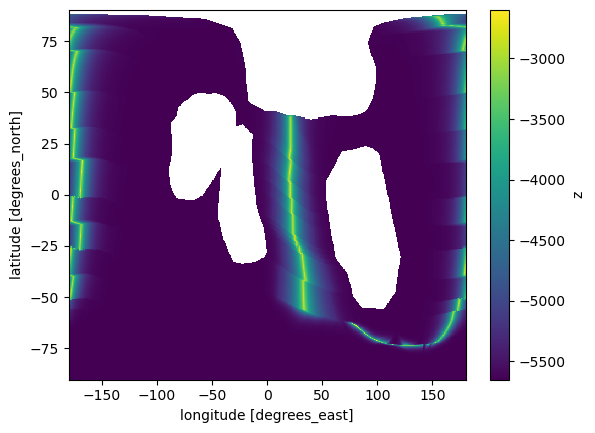

In [23]:
### 1 run paleoagegrid

#run_paleo_age_grids('/Users/simon/GIT/agegrid-0.1/config_files/config_Atlantis.yaml')
seafloor_age = pygmt.grdsample('./Atlantis2/masked/Atlantis2_seafloor_age_mask_0.0Ma.nc',
                               region='d', spacing='{:f}d'.format(final_grd_sampling)) #xr.load_dataarray('./Atlantis2/masked/Atlantis2_seafloor_age_mask_0.0Ma.nc')

seafloor_depth = seafloor_age.copy(deep=True)
seafloor_depth.data = pg.age2depth(seafloor_depth.data, model='GDH1')

seafloor_depth.plot()


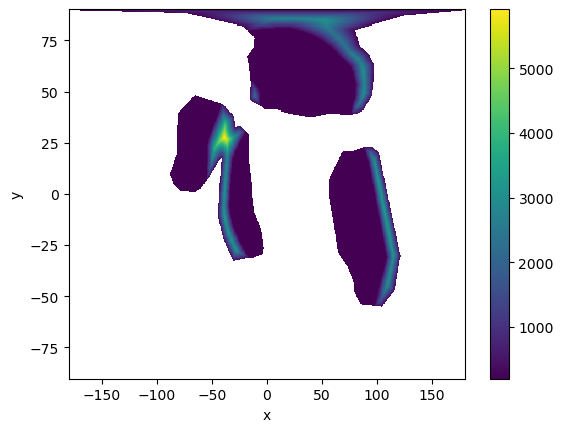

In [24]:
### 2 run make mountain ranges

reconstruction_model = Atlantis
reconstruction_time = 0.
min_distance_to_coastlines=0
max_distance_to_trenches=1200000
sampling = final_grd_sampling


rp = me.reconstruct_and_rasterize_polygons(reconstruction_model.continent_polygons[0], 
                                           reconstruction_model.rotation_model, 
                                           reconstruction_time=reconstruction_time, 
                                           sampling=sampling)

_, prox_ocean = me.raster_buffer(rp, inside='both')

# Get subduction zones, and compute a raster of distances to the nearest one
snapshot = reconstruction_model.plate_snapshot(reconstruction_time)

szs = snapshot.get_boundary_features(boundary_types=['subduction'])
all_sz_points = []
for sz in szs:
    if sz.get_geometry():
        all_sz_points.extend(sz.get_geometry().to_tessellated(np.radians(0.1)).to_lat_lon_list())

prox_sz = me.points_proximity(x=[lon for lat,lon in all_sz_points],
                              y=[lat for lat,lon in all_sz_points],
                              spacing=sampling)

# combine the rasters to isolate areas not too near to coastlines
# and not too far from subduction zones
m1 = prox_ocean.where((prox_ocean>min_distance_to_coastlines))
m2 = prox_sz.where(prox_sz<max_distance_to_trenches)
m2.data = m1.data+m2.data
#mountain_grid = m2

m2.data[np.isnan(m2.data)] = -999

mountain_core = proximity(m2, target_values=[-999], distance_metric='GREAT_CIRCLE')


land = prox_ocean.where(prox_ocean==0, 1)

topography = (mountain_core/200)+(land*200)
topography = topography.where(topography>0, np.nan)

topography.plot()



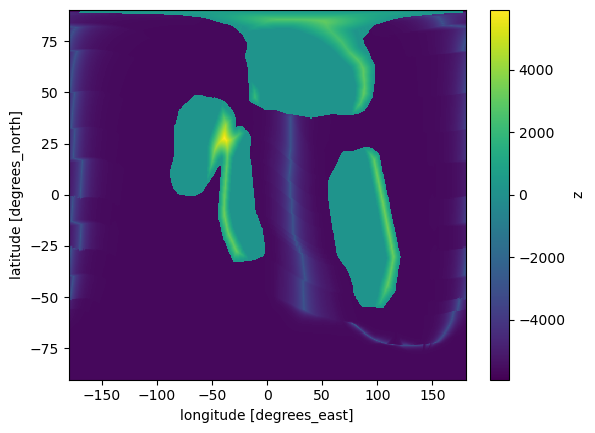

In [68]:
#seafloor_depth.plot(vmin=-5000,vmax=3000)
#topography.plot(vmin=-5000,vmax=3000)
from gprm.utils import inpaint


# recall that the coordinate names are inconsistent (x,y versus lat/lon)
merge = seafloor_depth.copy(deep=True)
merge.data = topography.data
merge = merge.where(np.isfinite(merge), seafloor_depth)#.data[np.isnan(topography.data)] = seafloor_depth.data[np.isnan(topography.data)]

#merge = pygmt.grdfill(merge, mode='s0.8', verbose='q')

#bm = pygmt.grd2xyz(merge).dropna().reset_index(drop=True)
#print('spherical interpolation step.....')
#merge = pygmt.sphinterpolate(data=bm, spacing=final_grd_sampling, region='d', Q=0)

#from rasterio.fill import fillnodata
#merge.data = fillnodata(merge.data, mask=np.isnan(merge.data), smoothing_iterations=10) 
merge.data = inpaint.fill_ndimage(merge.data)

merge.plot(cmap='viridis')



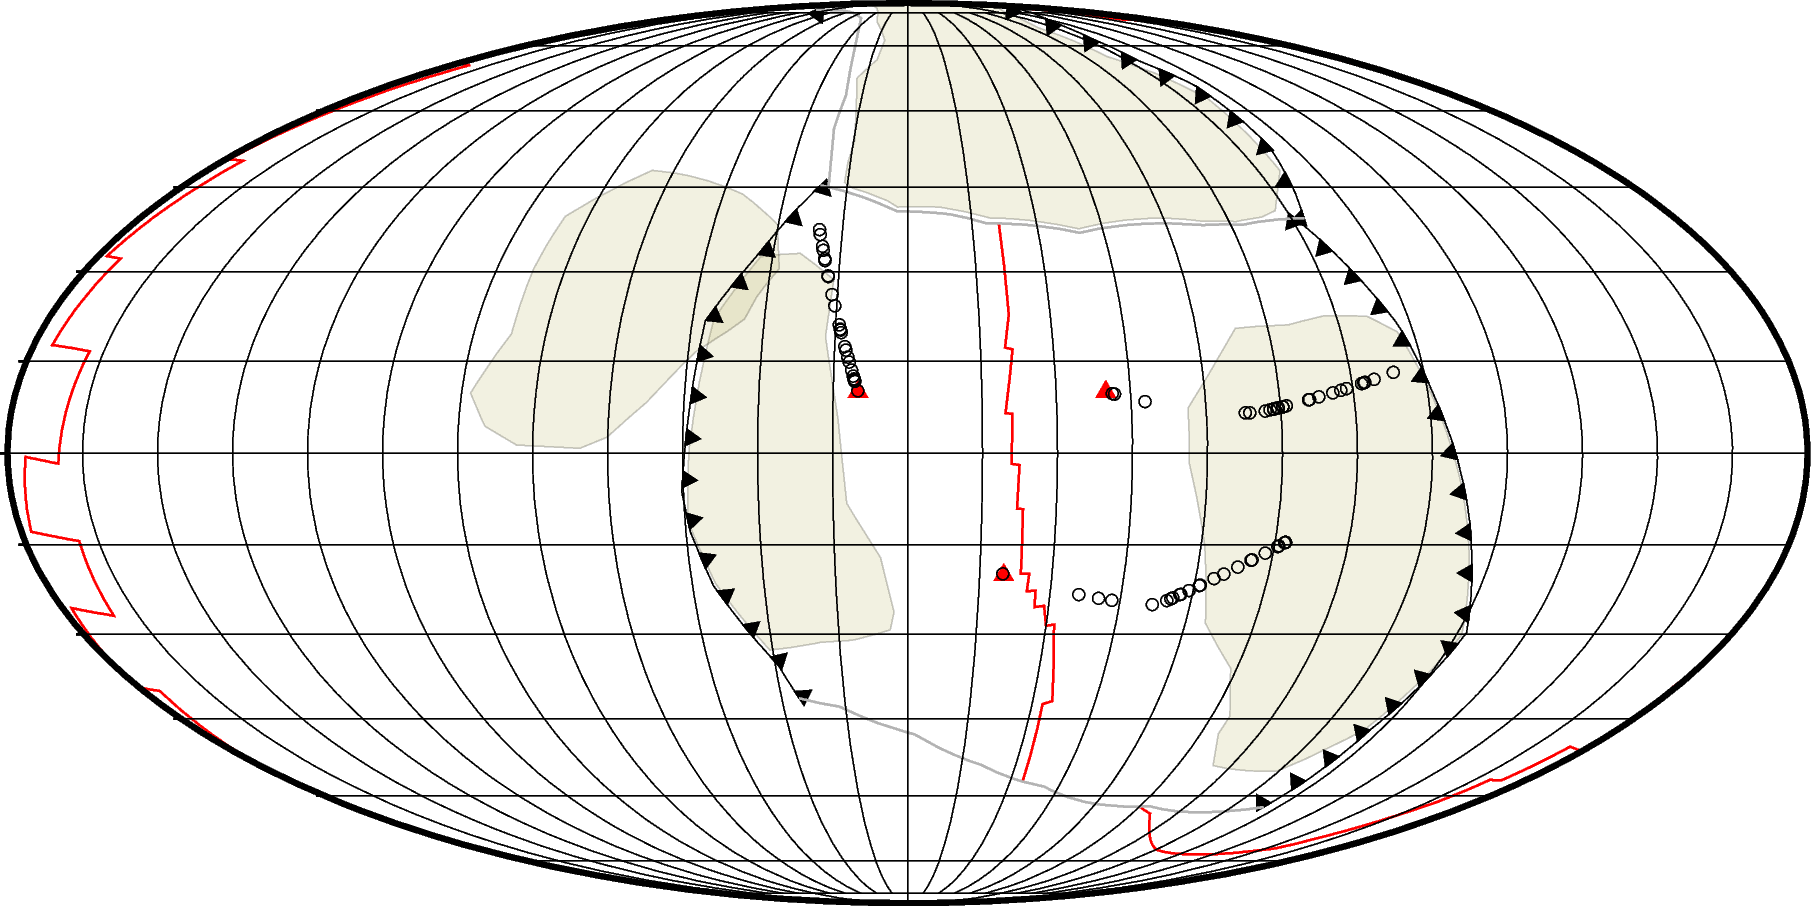

In [69]:
import pygplates
from gprm.utils.deformation import topological_reconstruction

DEFAULT_COLLISION = pygplates.ReconstructedGeometryTimeSpan.DefaultDeactivatePoints()

anchor_plate_id = 0
initial_time = 100
youngest_time = 0
time_increment = 1

### make seamounts and LIPs??
topological_model = pygplates.TopologicalModel(Atlantis.dynamic_polygons,
                                               Atlantis.rotation_model,
                                               anchor_plate_id=anchor_plate_id)

hot_spot_points = {
    'A':(10,-10), 
    'B':(-20,20), 
    'C':(10,40)
}
hot_spot_trail = {}

fig = pygmt.Figure()
region = 'd'
projection='W6i'
reconstruction_model.polygon_snapshot('continents', 0).plot(fig, transparency=80, region=region, projection=projection, fill='darkkhaki')
reconstruction_model.plate_snapshot(0).plot_boundaries(fig, region=region, projection=projection)

#fig.plot(x=list(zip(*hot_spot_points))[1], y=list(zip(*hot_spot_points))[0], style='t0.2c', fill='red')
fig.plot(x=[hot_spot_points[x][1] for x in hot_spot_points],
         y=[hot_spot_points[x][0] for x in hot_spot_points], 
         style='t0.2c', fill='red')
    
#reconstruction_times = np.arange(100,-1,-10)
for hot_spot_key in hot_spot_points:
    rp = []
    ra = []
    reconstruction_times = np.sort(np.random.uniform(0, 200, size=25))
    for reconstruction_time in reconstruction_times:

        reconstructed_points = topological_model.reconstruct_geometry(
            pygplates.PointOnSphere(hot_spot_points[hot_spot_key]),
            initial_time=reconstruction_time,
            oldest_time=200.,
            youngest_time=0.,
            time_increment=1)

        #print(reconstruction_time, reconstructed_points.get_geometry_points(0.))
        if reconstructed_points.get_geometry_points(0.):
            rp.append(reconstructed_points.get_geometry_points(0.)[0].to_lat_lon())
            ra.append(reconstruction_time)


    lonlats = list(zip(*rp))
    hot_spot_trail[hot_spot_key] = gpd.GeoDataFrame(data={'age': ra},
                                          geometry=gpd.points_from_xy(lonlats[1], lonlats[0]), 
                                          crs=4326)
    fig.plot(x=lonlats[1], y=lonlats[0], style='c0.1c')

fig.basemap(frame='fg', region=region, projection=projection)
fig.show(width=1000)


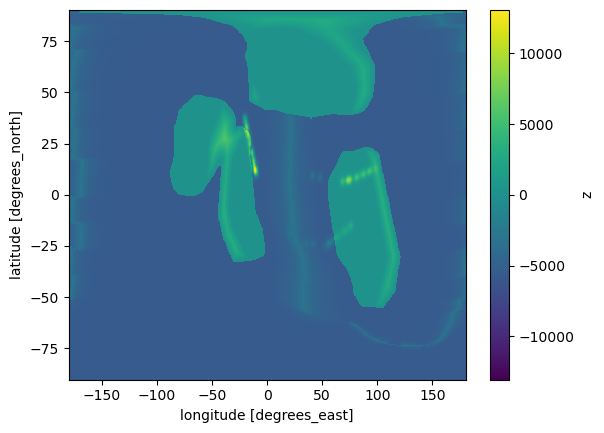

In [70]:
#hot_spot_trail['A']
import os
import xarray as xr
from ptt.utils.call_system_command import call_system_command

for hot_spot_key in hot_spot_trail.keys():

    d2sm = me.points_proximity(hot_spot_trail[hot_spot_key].geometry.x, 
                               hot_spot_trail[hot_spot_key].geometry.y, spacing=final_grd_sampling)
    d2sm = d2sm.where(d2sm>100.,100.)
    d2sm = (1./d2sm)


    filter_length_km = 1000
    #pygmt.grdfilter(tmp, filter='g{:f}k+h'.format(filter_length_km), 
    #                distance='2', coltypes='g').plot()
    d2sm.to_netcdf('./_tmp.nc')
    call_system_command(['gmt', 'grdfilter', '_tmp.nc', 
                         '-Fg{:f}k'.format(filter_length_km), '-D2', '-G_tmpp.nc', '-fg'])
    seamounts = xr.open_dataarray('./_tmpp.nc')
    os.remove('./_tmpp.nc')
    #"""

    seamounts = (seamounts/seamounts.data.max())*np.random.uniform(1000,20000,size=1)
    merge+=seamounts
#seamounts.plot()
merge.plot(cmap='viridis')


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


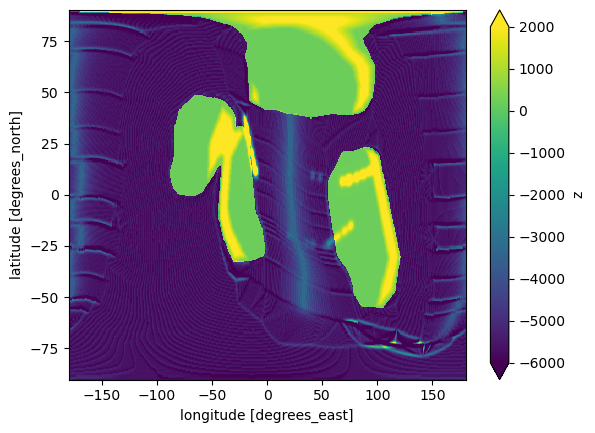

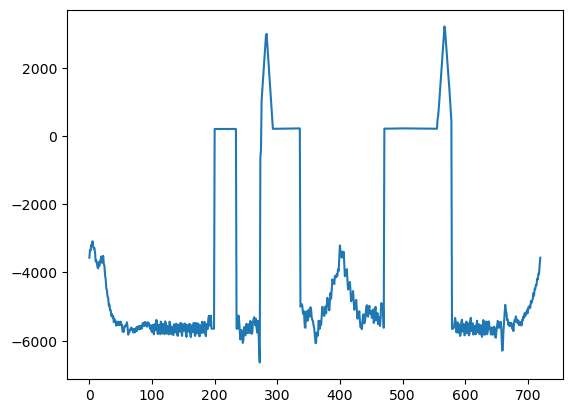

In [77]:
import sys, os
import numpy as np
sys.path.append('../sphipple/')
import xarray as xr
import matplotlib.pyplot as plt
import pygmt
import ptt.utils.call_system_command as call_system_command
import pyshtools

from stipple_scalar_grids_spherical import quantize_grid, mach_banding, write_netcdf_grid

def make_noise_grid(lmax=300, exponent=-2, scaling=1, spacing='6m'):
    degrees = np.arange(lmax+1, dtype=float)
    degrees[0] = np.inf

    power_per_degree = degrees**(exponent)
    power_per_degree[:200] = 0

    noise = pyshtools.SHCoeffs.from_random(power_per_degree, seed=None).expand().to_xarray()

    noise = pygmt.grdsample(noise, region='d', spacing=spacing)
    return noise*scaling


hp_filter_length_km = 500.
lp_filter_length_km = 250.


#agegrid = xr.open_dataarray('/Users/simon/Data/AgeGrids/2020/age.2020.1.GeeK2007.6m.nc')
agegrid = pygmt.grdsample('../octopus/Atlantis2/masked/Atlantis2_seafloor_age_mask_0.0Ma.nc',
                          region='d', spacing='{:f}d'.format(final_grd_sampling))
#agegrid.data += make_noise_grid(lmax=400, scaling=2.).data


quantized_raster = quantize_grid(agegrid, q=5.)

quantized_raster.data += make_noise_grid(lmax=400, scaling=5., spacing='{:f}d'.format(final_grd_sampling)).data

quantized_raster

write_netcdf_grid('qraster.nc', agegrid.lon.data, agegrid.lat.data, quantized_raster)
#filt_grid = pygmt.grdfilter(quantized_raster, 
#                            filter='g{:f}k+h'.format(filter_length_km), 
#                            distance='2', coltypes='g')

call_system_command(['gmt', 'grdfilter', 'qraster.nc', 
                     '-Fg{:f}k+h'.format(hp_filter_length_km), '-D2', '-Gmach_banded_raster.nc', '-fg'])
call_system_command(['gmt', 'grdfilter', 'mach_banded_raster.nc', 
                     '-Fg{:f}k'.format(lp_filter_length_km), '-D2', '-Gmach_banded_raster.nc', '-fg'])
filt_grid = xr.open_dataarray('./mach_banded_raster.nc')
os.remove('mach_banded_raster.nc')


#filt_grid = filt_grid+make_noise_grid(scaling=2.)

#fig,ax = plt.subplots(figsize=(20,10))
#filt_grid.plot(vmin=-2,vmax=2, ax=ax)

filt_grid = filt_grid.where(np.isfinite(filt_grid), 0)

mergef = merge + filt_grid*300
mergef.plot(vmin=-6000, vmax=2000)
plt.show()

plt.plot(mergef.data[180,:])

In [ ]:
## Make subduction trenches deep


### make magnetic maps


### Make geological age coded data (volcanos, metamorphic rocks, )

In [ ]:
sys.path.append('/Users/simon/GIT/vh0/notebooks/ModelGeneration/')
import ocean_remanence_vectors as orv

age_grid_filename = './Atlantis2/masked/Atlantis2_seafloor_age_mask_0.0Ma.nc'

snapshot = Atlantis.plate_snapshot(0.)

static_polygon_filename = './_tmp.shp'
fc = pygplates.FeatureCollection([rt.get_resolved_feature() for rt in snapshot.resolved_topologies])
fc.write(static_polygon_filename)

grd_spacing = final_grd_sampling

age_grid, plate_id_raster = orv.build_input_grids(age_grid_filename,
                                                  static_polygon_filename,
                                                  grd_spacing)

(paleo_latitude,
 paleo_declination) = orv.reconstruct_agegrid_to_birthtime(
    Atlantis, 
    age_grid, 
    plate_id_raster, 
    return_type='xarray')


In [ ]:
from remit.data.models import create_vim
from remit.utils.grid import coeffs2map
from remit.earthvim import SeafloorGrid, GlobalVIS

lmin = 16
lmax = 500
input_sampling = 0.1

GK07 = {'seafloor_layer':'2d',
        'layer_boundary_depths':[0,500,1500,6500], 
        'layer_weights':[5,2.3,1.2], 
        'MagMax':None, 
        'P':5, 
        'lmbda':3, 
        'Mtrm':1, 
        'Mcrm':0}


ocean = SeafloorGrid.from_xarray(age_grid, paleo_declination, paleo_latitude)
ocean.resample(shape=(1801,3601))

layer_params = GK07.copy()

vis = GlobalVIS.from_random(exponent=-1.5, scaling=0.1)
vis.resample(shape=(1801,3601))

#ocean.lon
totalvim = create_vim(ocean, vis, **layer_params)

totalvim.plot()
#plt.pcolormesh(totalvim.mphi, vmin=-10000, vmax=10000)
#plt.colorbar()
#print(vis)


In [ ]:
from remit.utils.grid import shmaggrid2tmi

vsh, coeffs = totalvim.transform(lmax=lmax)

#shmaggrid2tmi(coeffs.expand())

mp = coeffs2map(coeffs, altitude=80000, lmax=lmax, lmin=lmin)

fig,ax = plt.subplots(figsize=(20,10))
mp.plot(cmap='seismic', colorbar='right', ax=ax, cmap_limits=(-100,100))
plt.show()

In [ ]:
sys.path.append('/Users/simon/GIT/pgpslabs/')
import slab_tracker_utils as slab

topology_features = Atlantis.dynamic_polygons
rotation_model = Atlantis.rotation_model
start_time = 30.
end_time = 0.
time_step = 2.0
dip_angle_degrees = 45.0
line_tessellation_distance = np.radians(1.0)

agegrid_filename = None

subduction_boundary_sections = slab.getSubductionBoundarySections(
    topology_features,
    rotation_model,
    0.)



output_data = []
dip_angle_radians = np.radians(dip_angle_degrees)
time_list = np.arange(start_time,end_time-time_step,-time_step)


for time in time_list:
    
    print('time %0.2f Ma' % time)
    
    # call function to get subduction boundary segments
    subduction_boundary_sections = slab.getSubductionBoundarySections(topology_features,
                                                                      rotation_model,
                                                                      time)
    
    # Set up an age grid interpolator for this time, to be used
    # for each tessellated line segment
    #if agegrid_filename is not None:
    #grdfile = '%s%d%s' % (agegrid_filename[0],time,agegrid_filename[1])
    #grdfile = '../pgpslabs-Bec/agegrid_final_mask_0.grd'
    grdfile = '../agegrid-0.1/grid_files/unmasked/M16_seafloor_age_0.0Ma.nc'
    lut = slab.make_age_interpolator(grdfile)
    
    # Loop over each segment
    for segment_index,subduction_segment in enumerate(subduction_boundary_sections):
            
        # find the overrding plate id (and only continue if we find it)
        overriding_and_subducting_plates = slab.find_overriding_and_subducting_plates(subduction_segment,time)
                
        if not overriding_and_subducting_plates:
            continue
        overriding_plate, subducting_plate, subduction_polarity = overriding_and_subducting_plates

        overriding_plate_id = overriding_plate.get_resolved_feature().get_reconstruction_plate_id()
        subducting_plate_id = subducting_plate.get_resolved_feature().get_reconstruction_plate_id()
        
        subducting_plate_disappearance_time = -1.

        tessellated_line = subduction_segment.get_resolved_geometry().to_tessellated(line_tessellation_distance)

        #print len(tessellated_line.get_points())
        
        if agegrid_filename is not None:
            x = tessellated_line.to_lat_lon_array()[:,1]
            y = tessellated_line.to_lat_lon_array()[:,0]
            subduction_ages = lut.ev(np.radians(y+90.),np.radians(x+180.))
        else:
            # if no age grids, just fill the ages with zero
            subduction_ages = [0. for point in tessellated_line.to_lat_lon_array()[:,1]]
              
        # CALL THE MAIN WARPING FUNCTION
        (points, 
         point_depths, 
         polyline) = slab.warp_subduction_segment(tessellated_line,
                                                  rotation_model,
                                                  subducting_plate_id,
                                                  overriding_plate_id,
                                                  subduction_polarity,
                                                  time,
                                                  end_time,
                                                  time_step,
                                                  dip_angle_radians,
                                                  subducting_plate_disappearance_time)
        
        output_data.append(gpd.GeoDataFrame(
            data={'subduction_time':np.ones(len(point_depths)).T*time,
                  'depth': point_depths,
                  'age_at_subduction': subduction_ages},
            geometry=gpd.points_from_xy(polyline.to_lat_lon_array()[:,1], 
                                        polyline.to_lat_lon_array()[:,0]), 
            crs=4326))
        
present_day_slab = gpd.GeoDataFrame(
    gpd.pd.concat(output_data, ignore_index=True), crs=output_data[0].crs)
slab_earthquakes = present_day_slab.sample(200)


fig = plt.figure(figsize=(20,11))
ax = fig.add_subplot(111)
cm = ax.scatter(slab_earthquakes.geometry.x, 
                slab_earthquakes.geometry.y, 
                c=slab_earthquakes.depth, 
                s=50,
                cmap='magma_r', vmin=0., vmax=300)
ax.set_aspect('equal')
fig.colorbar(cm)
fig.show()